In [1]:
%load_ext autoreload
%autoreload 2

import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import concurrent.futures
import numpy as np

import warnings
from typing import Self
from datetime import datetime
from functools import reduce
from sklearn.metrics import precision_recall_curve, auc, roc_curve
from concurrent.futures import ThreadPoolExecutor, wait, FIRST_COMPLETED

import src.utils.anomalydetectors as m
import src.utils.globals as g
import src.utils.aggregators as agg

from src.utils.noise import NoiseFactory
from src.utils.plotting import plot_rpcurves
from src.utils.experiment import Experiment


In [2]:
def run_experiment(df : pd.DataFrame, models, columns, name):
    df['anomalous'] = df['anomaly_syn_type'] != ""
    df_anomalies = df.groupby('seqid').agg({'anomalous' : any})

    experiment = Experiment(name)
    experiment.run(df, models, (['seqid', 'timeindex_bin'], columns), verbose=True)
    experiment.set_input(df)
    experiment.set_anomalies(df_anomalies)
    experiment.calculate_metrics(models=models, aggrfunc=agg.aggr_sum)

    experiment.pickle()

    return experiment

def run_gaussian_experiment(df : pd.DataFrame, models, exp_columns, syn_column, ratio, intensity, robotids = []):
    name = f"gaussian_{ratio}_{intensity}"

    if robotids:
        df = df[df['robotid'].isin(robotids)]
        name = name + f"_{'_'.join(item.strip() for item in robotids)}"

    df_syn = NoiseFactory.gaussian(df, syn_column, ratio, intensity)
    return run_experiment(df_syn, models, exp_columns, name)

def run_sinusoidal_experiment(df : pd.DataFrame, models, columns, ratio, intensity, robotids = []):
    name = f"sinus_{ratio}_{intensity}"

    if robotids:
        df = df[df['robotid'].isin(robotids)]
        name = name + f"_{'_'.join(item.strip() for item in robotids)}"

    df_syn = NoiseFactory.sinusoidal(df, columns[0], ratio, intensity)
    return run_experiment(df_syn, models, columns, name)

def run_point_experiment(df : pd.DataFrame, models, columns, ratio, intensity, robotids = []):
    name = f"point_{ratio}_{intensity}"

    if robotids:
        df = df[df['robotid'].isin(robotids)]
        name = name + f"_{'_'.join(item.strip() for item in robotids)}"

    df_syn = NoiseFactory.point(df, columns[0], ratio, intensity)
    return run_experiment(df_syn, models, columns, name)


In [3]:
df_in = pd.read_parquet(g.path_imu)


In [ ]:
sampled_seqids = np.random.choice(df_in['seqid'].unique(), size=100, replace=False)
df_sampled = df_in[df_in['seqid'].isin(sampled_seqids)]

['2024.09.16|04.10.45' '2024.09.16|05.31.32' '2024.09.16|22.19.05'
 '2024.09.16|22.07.03' '2024.09.16|23.35.07' '2024.09.16|02.11.11'
 '2024.09.16|02.32.56' '2024.09.16|04.26.17' '2024.09.16|03.13.18'
 '2024.09.16|05.57.58' '2024.09.16|02.23.37' '2024.09.16|05.45.32'
 '2024.09.16|03.38.08' '2024.09.16|03.56.47' '2024.09.16|06.18.10'
 '2024.09.16|00.07.16' '2024.09.16|04.07.39' '2024.09.16|23.19.47'
 '2024.09.16|00.16.35' '2024.09.16|23.48.38' '2024.09.16|20.51.52'
 '2024.09.16|23.39.37' '2024.09.16|22.39.24' '2024.09.16|05.02.00'
 '2024.09.16|22.34.53' '2024.09.16|02.03.25' '2024.09.16|00.11.55'
 '2024.09.16|06.49.15' '2024.09.16|22.42.25' '2024.09.16|04.18.31'
 '2024.09.16|05.37.46' '2024.09.16|22.40.54' '2024.09.16|02.51.34'
 '2024.09.16|05.09.47' '2024.09.16|05.16.00' '2024.09.16|23.12.16'
 '2024.09.16|23.18.17' '2024.09.16|03.42.48' '2024.09.16|05.33.06'
 '2024.09.16|02.37.36' '2024.09.16|04.30.56' '2024.09.16|05.25.19'
 '2024.09.16|03.28.50' '2024.09.16|11.44.40' '2024.09.16|05.36

In [11]:
models = {"lof5" : m.LOF(n_neighbors=5, name="lof5"), 
          "lof15" : m.LOF(n_neighbors=15, name="lof15"), 
          "lof30" : m.LOF(n_neighbors=30, name="lof30"), 
          "lof50" : m.LOF(n_neighbors=50, name="lof50")}
exp_columns = [f'acceleration_{x}' for x in ['x', 'y', 'z']]

df_in[exp_columns].isnull().sum()

acceleration_x    0
acceleration_y    0
acceleration_z    0
dtype: int64

# GAUSSIAN

In [12]:
exps_gaussian = {}
for intensity in [0.05, 0.25]:
    print(f"Running Experiment gaussian {intensity}")
    exp = run_gaussian_experiment(df_sampled, models, exp_columns, exp_columns[0], ratio=0.1, intensity=intensity)
    exps_gaussian[exp.name] = exp
    

Running Experiment gaussian 0.05
model_fit_scores lof5 for 1 on (['seqid', 'timeindex_bin'], ['acceleration_x', 'acceleration_y', 'acceleration_z'])
model_fit_scores lof15 for 1 on (['seqid', 'timeindex_bin'], ['acceleration_x', 'acceleration_y', 'acceleration_z'])
model_fit_scores lof30 for 1 on (['seqid', 'timeindex_bin'], ['acceleration_x', 'acceleration_y', 'acceleration_z'])
model_fit_scores lof50 for 1 on (['seqid', 'timeindex_bin'], ['acceleration_x', 'acceleration_y', 'acceleration_z'])
        timeindex_bin                         seqid  timeindex  rotation_real  \
0                   0  2024.09.16|00.07.16|original   0.000000       0.758423   
1                   1  2024.09.16|00.07.16|original   0.014218       0.758423   
2                   2  2024.09.16|00.07.16|original   0.049685       0.758423   
3                   3  2024.09.16|00.07.16|original   0.069244       0.758423   
4                   4  2024.09.16|00.07.16|original   0.088804       0.758423   
...           

In [ ]:
tmp = exp.results['df']

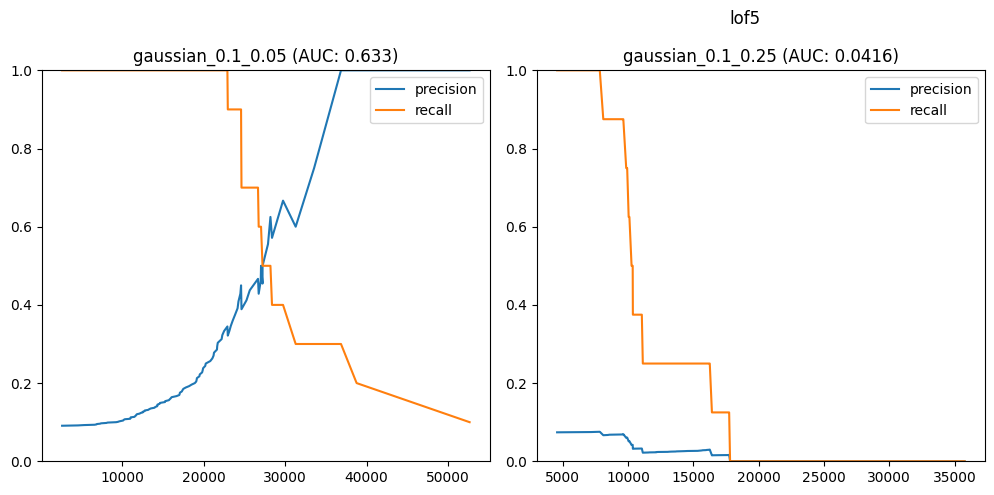

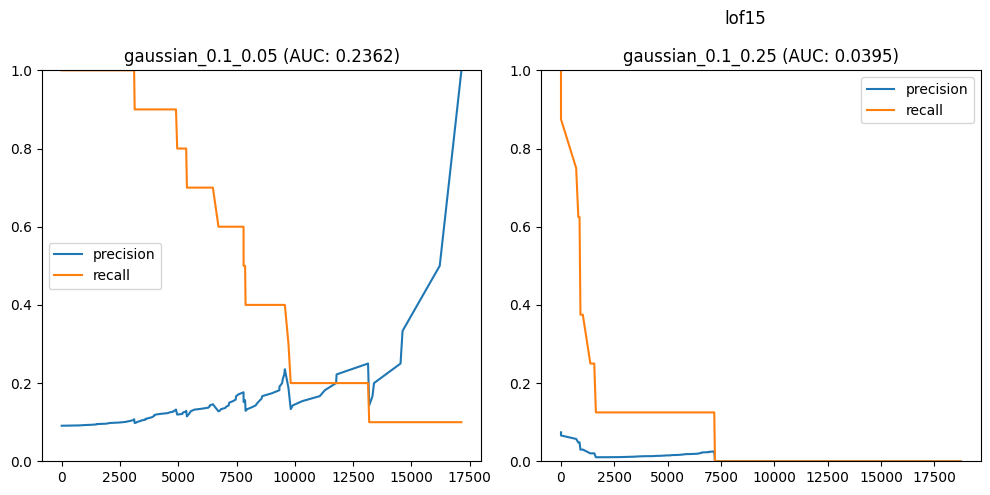

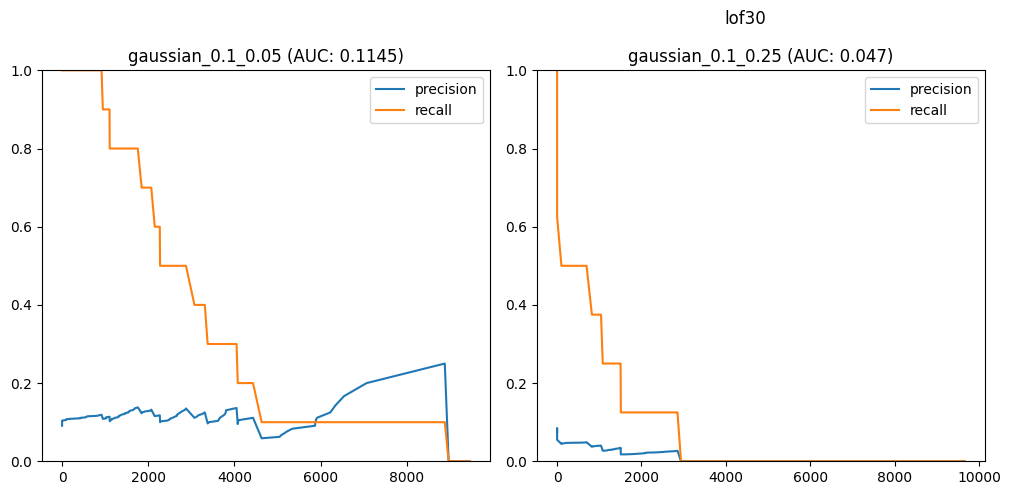

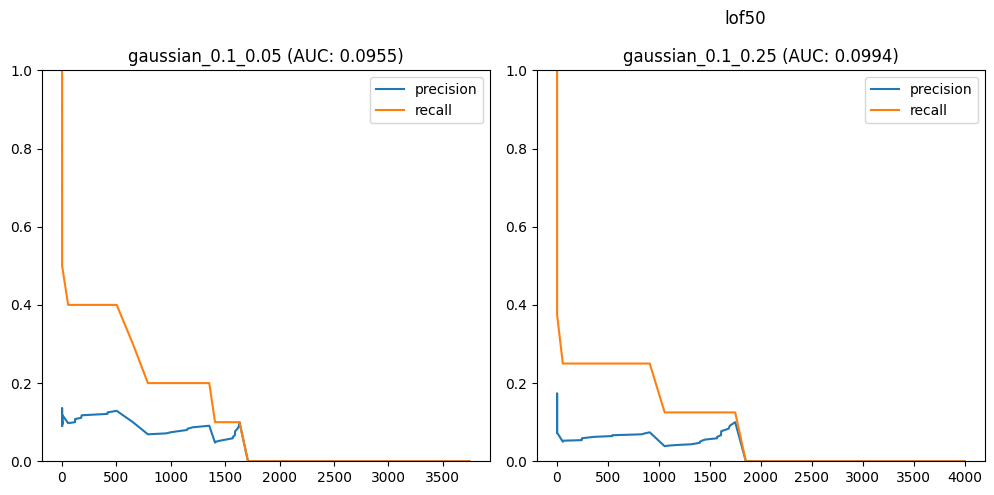

In [13]:
rp_curves = {}
for (mname, _) in models.items():
    rp_curves[mname] = {}
    for (ename, exp) in exps_gaussian.items():
        rp_curves[mname][ename] = exp.results['pr'][mname]
    with warnings.catch_warnings(action="ignore"):
        plot_rpcurves(rp_curves[mname], colnums=3, title=mname, auc=True, f1=False)

In [ ]:
def plot_acceleration(df, seqid):
    df_seqid = df[df['seqid'] == seqid]

    plt.figure(figsize=(12, 6))
    plt.plot(df_seqid['timeindex'], df_seqid['acceleration_x'], label='Acceleration X')
    plt.plot(df_seqid['timeindex'], df_seqid['acceleration_y'], label='Acceleration Y')
    plt.plot(df_seqid['timeindex'], df_seqid['acceleration_z'], label='Acceleration Z')
    plt.xlabel('Time Index')
    plt.ylabel('Acceleration')
    plt.title(f'Acceleration Data for seqid: {seqid}')
    plt.legend()
    plt.show()


tmpdf = list(exps_gaussian.items())[0][1].results['input']
seqid = "2024.09.16|04.21.37|original"
plot_acceleration(tmpdf, seqid)


In [ ]:
df_seqid = tmpdf[tmpdf['seqid'] == seqid]
duplicates = df_seqid[df_seqid.duplicated(subset=['seqid', 'timeindex_bin'], keep=False)]
print(duplicates)

# SINUSOIDAL

In [ ]:
exps_sinusoidal = {}
for intensity in [0.25, 0.5, 0.75, 1, 1.5, 2]:
    print(f"Running Experiment sinusoidal {intensity}")
    exp = run_sinusoidal_experiment(df_in, models, exp_columns, exp_columns[0], ratio=0.1, intensity=intensity)
    exps_sinusoidal[exp.name] = exp

In [ ]:
rp_curves = {}
for (mname, _) in models.items():
    rp_curves[mname] = {}
    for (ename, exp) in exps_sinusoidal.items():
        rp_curves[mname][ename] = exp.results['pr'][mname]
    with warnings.catch_warnings(action="ignore"):
        plot_rpcurves(rp_curves[mname], colnums=3, title=mname, auc=True, f1=False)

# POINT

In [ ]:
exps_point = {}
for intensity in [1, 5, 10, 100]:
    print(f"Running Experiment point {intensity}")
    exp = run_point_experiment(df_in, models, ['torqueactual'], ratio=0.1, intensity=intensity, robotids=ids)
    exps_point[exp.name] = exp

In [ ]:
rp_curves = {}
for (mname, _) in models.items():
    rp_curves[mname] = {}
    for (ename, exp) in exps_point.items():
        rp_curves[mname][ename] = exp.results['pr'][mname]
    plot_rpcurves(rp_curves[mname], colnums=3, title=mname)   

In [ ]:
# for intensity in [0.025, 0.05, 0.075, 0.1, 0.125, 0.15]:
#     print(f"Running Experiment gaussian {intensity}")
#     run_gaussian_experiment(df_in, models, ['torqueactual'], 0.1, intensity)
# for intensity in [0.25, 0.5, 0.75, 1, 1.25, 1.5]:
#     print(f"Running Experiment point {intensity}")
#     run_point_experiment(df_in, models, ['torqueactual'], 0.1, intensity)
#     print(f"Running Experiment sinusoidal {intensity}")
#     run_sinusoidal_experiment(df_in, models, ['torqueactual'], 0.1, intensity)

In [ ]:
folder_path = g.experiments_folder_path

files_to_unpickle = [
    file for file in os.listdir(folder_path)
    if os.path.isfile(os.path.join(folder_path, file)) and file.endswith("6640-102140-1")
]

files_to_unpickle


In [ ]:
unpickled_data = {}
for file_name in files_to_unpickle:
    unpickled_data[file_name] = Experiment.unpickle(file_name)    
    
for (name, exp) in unpickled_data.items():
    print(f"{name} - {exp.results['auc-pr']}")